<a href="https://colab.research.google.com/github/michalmac89/cs230finalproject/blob/main/Pytorch_COVID_19_ResNet18_Model_With_under_and_over_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import os
import torch
import random
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        all_images = self.images[self.class_names[0]] \
          + self.images[self.class_names[1]] \
          + self.images[self.class_names[2]]
        all_class_names = [self.class_names[0]]*len(self.images[self.class_names[0]]) \
          + [self.class_names[1]]*len(self.images[self.class_names[1]]) \
          + [self.class_names[2]]*len(self.images[self.class_names[2]])
        image_name = all_images[index]
        class_name = all_class_names[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dirs = { 
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, transform)

Found 1221 normal examples
Found 1225 viral examples
Found 99 covid examples


In [ ]:
dev_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/covid'
}
dev_dataset = ChestXRayDataset(dev_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
test_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_dev = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of dev batches', len(dl_dev))
print('Number of test batches', len(dl_test))

Number of training batches 425
Number of dev batches 15
Number of test batches 15


In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

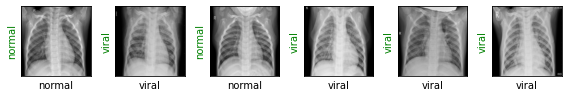

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

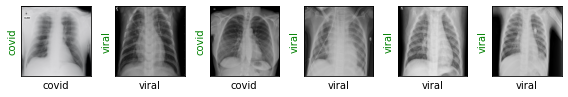

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_dev))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [ ]:
show_preds()

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f'Train Loss: {train_loss:.4f}')
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_dev):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Dev Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train() # set model to training phase

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
%%time

train(epochs=1)

In [ ]:
resnet18.eval()
labels_all = []
preds_all = []
for i, (images, labels) in enumerate(dl_test):
    output = resnet18(images)
    _, preds = torch.max(output, 1)
    labels_all += labels
    preds_all += preds

In [ ]:
comparison_df = pd.DataFrame(labels_all).rename(columns={0: 'labels'})
comparison_df['preds'] = [int(preds_all_el) for preds_all_el in preds_all]
comparison_df['misclassified'] = comparison_df.apply(lambda col: col['labels'] != col['preds'], axis=1)
comparison_df.head()

In [ ]:
comparison_df[comparison_df['misclassified'] == True]

In [ ]:
resnet18.eval() # set model to eval phase

nb_classes = 3

with torch.no_grad():
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for i, (images, labels) in enumerate(dl_test):
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

    print(class_names)
    print(confusion_matrix)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model
import sys
#sys.path.append('drive/My Drive/Colab Notebooks/')
#import util

In [ ]:
print(len(dl_train))

425


In [ ]:
images, labels = next(iter(dl_train))
print('images shape on batch size  = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size  = torch.Size([6, 3, 224, 224])
labels shape on batch size = torch.Size([6])


In [ ]:
print(labels)

tensor([0, 1, 1, 0, 0, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


viral


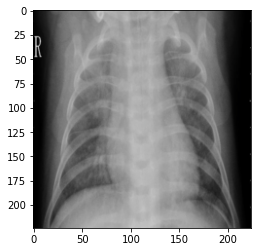

In [ ]:
index=1
image = images[index]
image = image.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = image * std + mean
plt.imshow(image)
print(class_names[int(labels[index].numpy())])

In [ ]:
print(train_dataset.class_names)

['normal', 'viral', 'covid']


In [ ]:
count = {}
for key, values in train_dataset.images.items():
  count[key] = len(values)

In [ ]:
print(count)

{'normal': 1221, 'viral': 1225, 'covid': 99}


In [ ]:

from IPython import display

# kill error when executing argparse in IPython console
import sys; sys.argv=['']; del sys

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [ ]:
import argparse
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm

# parse arguments
parser = argparse.ArgumentParser(description='Imbalanced Dataset Example')
parser.add_argument('--data', metavar='DIR', default='./data/oven', help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=6, type=int,
                    metavar='N', help='mini-batch size (default: 6)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
args = parser.parse_args()
use_cuda = not args.no_cuda ##and torch.cuda.is_available()

torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Data loading code
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, 
    shuffle=True, sampler=None, **kwargs)

test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=args.batch_size, 
    shuffle=False, **kwargs)

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def process(train_loader, test_loader):
    
    model = torchvision.models.__dict__[args.arch]()
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model ##.cuda()
    else:
        model = torch.nn.DataParallel(model) ##.cuda()

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss() ##.cuda()
    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # train & test process
    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, args.epochs + 1):
        adjust_learning_rate(optimizer, epoch)
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)
        
    vis(test_accs, confusion_mtxes, classe_labels)

In [ ]:
labels = [list(np.repeat(label,len(values))) for label, values in train_loader.dataset.images.items()]

In [ ]:
labels = [ li for i in labels for li in i]

In [ ]:
print(labels)

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

Dataset: 2545 training samples & 90 testing samples

Distribution of classes in dataset:


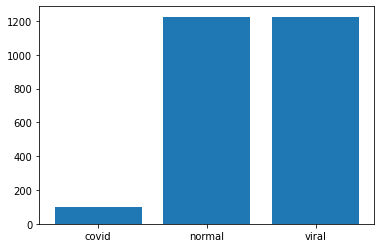

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
        
!pip install seaborn
import seaborn as sns

print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = labels
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [ ]:
process(train_loader, test_loader)

In [ ]:
isinstance(train_dataset, torch.utils.data.Subset)

In [ ]:
isinstance(train_dataset, ChestXRayDataset)

In [ ]:
train_dataset.__getitem__(0)[1]


In [ ]:
type(train_dataset)

In [ ]:
len(train_dataset)

In [ ]:
indices = list(range(len(train_dataset)))

In [ ]:
len(indices)

In [ ]:
train_dataset.__getitem__(2)[1]

0

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Oct 28 06:41:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!python -m torch.utils.collect_env

PyTorch version: 1.7.0+cu101
Is debug build: True
CUDA used to build PyTorch: 10.1
ROCM used to build PyTorch: N/A

OS: Ubuntu 18.04.5 LTS (x86_64)
GCC version: (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Clang version: 6.0.0-1ubuntu2 (tags/RELEASE_600/final)
CMake version: version 3.12.0

Python version: 3.6 (64-bit runtime)
Is CUDA available: False
CUDA runtime version: 10.1.243
GPU models and configuration: GPU 0: Tesla P100-PCIE-16GB
Nvidia driver version: 418.67
cuDNN version: /usr/lib/x86_64-linux-gnu/libcudnn.so.7.6.5
HIP runtime version: N/A
MIOpen runtime version: N/A

Versions of relevant libraries:
[pip3] numpy==1.18.5
[pip3] torch==1.7.0+cu101
[pip3] torchaudio==0.7.0
[pip3] torchsummary==1.5.1
[pip3] torchtext==0.3.1
[pip3] torchvision==0.8.1+cu101
[conda] Could not collect


In [ ]:
torch.cuda.is_available()

False

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
    
        # distribution of classes in the dataset 
        label_to_count = {}
        ##print(label_to_count)
        ##print("len(self.indices): ", len(self.indices))
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        ##print(len(label_to_count))      
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, ChestXRayDataset):
            ##print(dataset.__getitem__(idx)[1])
            return dataset.__getitem__(idx)[1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
sampler = ImbalancedDatasetSampler(train_dataset)

Best test acc = 96.67%

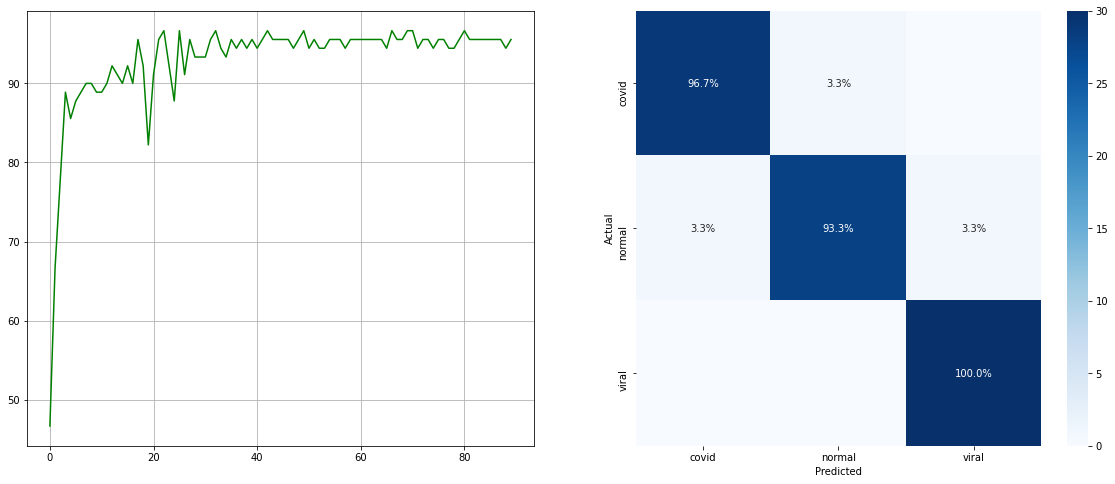

In [ ]:
process(torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, 
    sampler= sampler,
    **kwargs), test_loader)

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3MB 11kB/s 
     |████████████████████████████████| 12.8MB 245kB/s 
     |████████████████████████████████| 7.6MB 2.7MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
